<p style="background-color: #0055A4; font-size: 48px; font-weight: bold; color: white; padding: 20px; text-align: center;">
🧹 Data Cleaning 
</p>


In [32]:
#Import librairies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math 
from scipy.stats import pearsonr
import scipy.stats as stats
from plotly.subplots import make_subplots
from scipy.stats import shapiro
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore") 
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn import preprocessing
import plotly.graph_objects as go
import plotly.express as px
import missingno as msno
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import skew, shapiro
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
import itertools
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
import shap
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from collections import Counter
from sklearn.feature_selection import SelectKBest
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from prettytable import PrettyTable
import featuretools as ft

In [33]:
#Import data
train_df = pd.read_csv('C:/Users/Mega-Pc/Freelance/data/fraudTrain.csv', delimiter=',', encoding='utf-8',index_col=0)
test_df = pd.read_csv('C:/Users/Mega-Pc/Freelance/data/fraudTest.csv', delimiter=',', encoding='utf-8',index_col=0)



## 🔄 Check for duplicates

In [34]:
#train_df
duplicate_count = train_df.duplicated().sum()
print(f'Number of duplicate records: {duplicate_count}')


Number of duplicate records: 0


In [35]:
#train_df
duplicate_count = test_df.duplicated().sum()
print(f'Number of duplicate records: {duplicate_count}')


Number of duplicate records: 0


## ✨ Data Transformation

## Log Transformation

In [36]:
#train_df + test_df
skewed_cols = ['amt','city_pop']
for col in skewed_cols:
    train_df[col] = np.log1p(train_df[col])  
    test_df[col] = np.log1p(test_df[col])
     




In [37]:
results = []
for var in  skewed_cols:
    skewness = stats.skew(train_df[var])
    kurtosis = stats.kurtosis(train_df[var])
    
    results.append({
        'Feature':  var ,
        'Skewness': skewness,
        'Kurtosis': kurtosis
    })

results_df = pd.DataFrame(results)

display(results_df)

,Feature,Skewness,Kurtosis
0,amt,-0.298852,-0.527247
1,city_pop,0.606094,-0.301258


## Handle outliers by capping them 

In [38]:
numerical_vars_filtered = [
    "amt",
    "zip",
    "lat",
    "long",
    "city_pop",
    "unix_time",
    "merch_lat",
    "merch_long"
]


In [39]:
#train_df
outliers_info = []

for col in numerical_vars_filtered:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)]
    
    outliers_info.append({
        'Feature': col,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers Count': len(outliers),
        'Total Points': len(train_df)
    })

outliers_df = pd.DataFrame(outliers_info)
print(outliers_df)


      Feature   Lower Bound   Upper Bound  Outliers Count  Total Points
0         amt -7.348234e-01  7.532865e+00             818       1296675
1         zip -4.247050e+04  1.407495e+05               0       1296675
2         lat  2.364065e+01  5.292025e+01            4679       1296675
3        long -1.217580e+02 -5.519800e+01           49922       1296675
4    city_pop  1.650397e+00  1.488145e+01            4168       1296675
5   unix_time  1.307799e+09  1.390337e+09               0       1296675
6   merch_lat  2.389818e+01  5.279255e+01            4967       1296675
7  merch_long -1.218880e+02 -5.524608e+01           41994       1296675


In [40]:
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.clip(df[column], lower_bound, upper_bound)
    return df

columns_with_outliers = [
    "amt",
    "lat",
    "long",
    "city_pop",
    "merch_lat",
    "merch_long"
]

for col in columns_with_outliers:
    train_df = handle_outliers(train_df, col)


In [41]:
# results after capping outliers
outliers_info = []

for col in numerical_vars_filtered:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)]
    
    outliers_info.append({
        'Feature': col,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers Count': len(outliers),
        'Total Points': len(train_df)
    })

outliers_df = pd.DataFrame(outliers_info)
print(outliers_df)


      Feature   Lower Bound   Upper Bound  Outliers Count  Total Points
0         amt -7.348234e-01  7.532865e+00               0       1296675
1         zip -4.247050e+04  1.407495e+05               0       1296675
2         lat  2.364065e+01  5.292025e+01               0       1296675
3        long -1.217580e+02 -5.519800e+01               0       1296675
4    city_pop  1.650397e+00  1.488145e+01               0       1296675
5   unix_time  1.307799e+09  1.390337e+09               0       1296675
6   merch_lat  2.389818e+01  5.279255e+01               0       1296675
7  merch_long -1.218880e+02 -5.524608e+01               0       1296675


In [42]:
#test_df
outliers_info = []

for col in numerical_vars_filtered:
    Q1 = test_df[col].quantile(0.25)
    Q3 = test_df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = test_df[(test_df[col] < lower_bound) | (test_df[col] > upper_bound)]
    
    outliers_info.append({
        'Feature': col,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers Count': len(outliers),
        'Total Points': len(train_df)
    })

outliers_df = pd.DataFrame(outliers_info)
print(outliers_df)


      Feature   Lower Bound   Upper Bound  Outliers Count  Total Points
0         amt -7.372033e-01  7.531819e+00             402       1296675
1         zip -4.228650e+04  1.405895e+05               0       1296675
2         lat  2.383005e+01  5.273365e+01            1933       1296675
3        long -1.217322e+02 -5.524100e+01           21104       1296675
4    city_pop  1.691879e+00  1.480513e+01            1697       1296675
5   unix_time  1.361271e+09  1.400625e+09               0       1296675
6   merch_lat  2.395701e+01  5.275246e+01            2090       1296675
7  merch_long -1.218659e+02 -5.530390e+01           17926       1296675


In [43]:
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.clip(df[column], lower_bound, upper_bound)
    return df

columns_with_outliers = [
    "amt",
    "lat",
    "long",
    "city_pop",
    "merch_lat",
    "merch_long"
]

for col in columns_with_outliers:
    train_df = handle_outliers(test_df, col)


In [44]:
# results after capping outliers
outliers_info = []

for col in numerical_vars_filtered:
    Q1 = test_df[col].quantile(0.25)
    Q3 = test_df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = test_df[(test_df[col] < lower_bound) | (test_df[col] > upper_bound)]
    
    outliers_info.append({
        'Feature': col,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers Count': len(outliers),
        'Total Points': len(train_df)
    })

outliers_df = pd.DataFrame(outliers_info)
print(outliers_df)


      Feature   Lower Bound   Upper Bound  Outliers Count  Total Points
0         amt -7.372033e-01  7.531819e+00               0        555719
1         zip -4.228650e+04  1.405895e+05               0        555719
2         lat  2.383005e+01  5.273365e+01               0        555719
3        long -1.217322e+02 -5.524100e+01               0        555719
4    city_pop  1.691879e+00  1.480513e+01               0        555719
5   unix_time  1.361271e+09  1.400625e+09               0        555719
6   merch_lat  2.395701e+01  5.275246e+01               0        555719
7  merch_long -1.218659e+02 -5.530390e+01               0        555719


## Feature Engineering

In [45]:
# extract age

from datetime import datetime
def add_age_feature(df):
    df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
    today_year = datetime.today().year
    df['age'] = today_year - df['dob'].dt.year

    df['age_group'] = pd.cut(
        df['age'],
        bins=[0, 25, 40, 60, 100],
        labels=['young', 'adult', 'mature', 'senior'] 
    )
    
    return df


train_df = add_age_feature(train_df)
test_df = add_age_feature(test_df)

In [46]:
# transaction amount per city pop and categorization into bins
def add_transaction_features(df):
    
    #Transaction amount per city pop
    df["amt_per_capita"] = df["amt"] / (df["city_pop"] + 1)  
    
    #Transaction amount bins 
    df["amt_category"] = pd.qcut(df["amt"], q=3, labels=["low", "medium", "high"]) 
    
    return df

# Apply to both train and test
train_df = add_transaction_features(train_df)
test_df = add_transaction_features(test_df)

train_df[["amt", "amt_per_capita", "amt_category"]].head()


,amt,amt_per_capita,amt_category
0,1.350667,0.098464,low
1,3.428813,0.510716,medium
2,3.744314,0.327054,medium
3,4.111693,0.345205,medium
4,1.432701,0.178478,low


In [47]:
#distance between customer and merchant (3 methods)

def haversine_distance(lat1, lon1, lat2, lon2):
    
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371  
    return c * r

def add_distance_features(df):
    df["haversine_dist"] = haversine_distance(
        df["lat"], df["long"], df["merch_lat"], df["merch_long"]
    )
    
    df["manhattan_dist"] = (
        abs(df["lat"] - df["merch_lat"]) + abs(df["long"] - df["merch_long"])
    )
    
    df["euclidean_dist"] = np.sqrt(
        (df["lat"] - df["merch_lat"])**2 + (df["long"] - df["merch_long"])**2
    )
    
    return df


train_df = add_distance_features(train_df)
test_df = add_distance_features(test_df)





In [48]:
# customer level aggregation features 
def add_customer_agg_features(train_df, test_df):
    customer_stats = train_df.groupby("cc_num").agg(
        avg_transaction_amt=("amt", "mean"),
        std_transaction_amt=("amt", "std"),
        transaction_count=("amt", "count")
    ).reset_index()
    
    train_df = train_df.merge(customer_stats, on="cc_num", how="left")
    
    test_df = test_df.merge(customer_stats, on="cc_num", how="left")
    
    train_df["std_transaction_amt"].fillna(0, inplace=True)
    test_df["std_transaction_amt"].fillna(0, inplace=True)
    
    return train_df, test_df


train_df, test_df = add_customer_agg_features(train_df, test_df)



In [49]:
#transaction velocity (1hour/24hours/7days)

def add_transaction_velocity(df):
    df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
    df = df.sort_values(by=["cc_num", "trans_date_trans_time"]).reset_index(drop=True)
    
    tx_1h = np.zeros(len(df), dtype=int)
    tx_24h = np.zeros(len(df), dtype=int)
    tx_7d = np.zeros(len(df), dtype=int)
    
    for cust_id, group in df.groupby("cc_num", sort=False):
        idx = group.index.values
        times = group["trans_date_trans_time"].values.astype("datetime64[ns]")
        times_ns = times.astype("int64")
        
        one_hour = np.timedelta64(1, "h").astype("int64")
        one_day = np.timedelta64(1, "D").astype("int64")
        seven_days = np.timedelta64(7, "D").astype("int64")
        
        for arr, window in [(tx_1h, one_hour), (tx_24h, one_day), (tx_7d, seven_days)]:
            left_idx = np.searchsorted(times_ns, times_ns - window, side="left")
            count = np.arange(len(times)) - left_idx
            arr[idx] = count
    
    df["tx_count_last_1h"] = tx_1h
    df["tx_count_last_24h"] = tx_24h
    df["tx_count_last_7d"] = tx_7d
    
    return df

train_df = add_transaction_velocity(train_df)
test_df = add_transaction_velocity(test_df)


In [50]:
#Transaction Amount Deviation to capture how unusual a transaction is for a customer

#amt_diff_mean=current transaction minus customer’s mean transaction amount
#amt_diff_std =current transaction – mean) divided by customer’s std
#amt_ratio_mean=ratio of current transaction to customer’s mean

def add_amount_deviation_features(train_df, test_df):
    customer_stats = train_df.groupby("cc_num")["amt"].agg(["mean", "std"]).reset_index()
    customer_stats.rename(columns={"mean": "cust_amt_mean", "std": "cust_amt_std"}, inplace=True)
    
    train_df = train_df.merge(customer_stats, on="cc_num", how="left")
    test_df = test_df.merge(customer_stats, on="cc_num", how="left")
    
    train_df["cust_amt_std"].fillna(0, inplace=True)
    test_df["cust_amt_std"].fillna(0, inplace=True)
    
    for df in [train_df, test_df]:
        df["amt_diff_mean"] = df["amt"] - df["cust_amt_mean"]
        df["amt_diff_std"] = (df["amt"] - df["cust_amt_mean"]) / (df["cust_amt_std"] + 1e-6)
        df["amt_ratio_mean"] = df["amt"] / (df["cust_amt_mean"] + 1e-6)
    
    return train_df, test_df


train_df, test_df = add_amount_deviation_features(train_df, test_df)




In [51]:
#Merchant-Level Aggregation Features because fraud can target certain merchants or categories

#merchant_avg_amt=average transaction amount per merchant
#merchant_tx_count=number of transactions per merchant
#merchant_fraud_rate =fraud rate per merchant 

def add_merchant_agg_features(train_df, test_df):
    merchant_stats = train_df.groupby("merchant").agg(
        merchant_avg_amt=("amt", "mean"),
        merchant_tx_count=("amt", "count"),
        merchant_fraud_rate=("is_fraud", "mean") 
    ).reset_index()
    
    train_df = train_df.merge(merchant_stats, on="merchant", how="left")
    test_df = test_df.merge(merchant_stats, on="merchant", how="left")

    global_fraud_rate = train_df["is_fraud"].mean()
    test_df["merchant_fraud_rate"].fillna(global_fraud_rate, inplace=True)
    
    return train_df, test_df

train_df, test_df = add_merchant_agg_features(train_df, test_df)



In [52]:
# city fraud rate & state fraud rate

def add_geographical_features(train_df, test_df):
    state_stats = train_df.groupby("state")["is_fraud"].mean().reset_index()
    state_stats.rename(columns={"is_fraud": "state_fraud_rate"}, inplace=True)

    city_stats = train_df.groupby("city")["is_fraud"].mean().reset_index()
    city_stats.rename(columns={"is_fraud": "city_fraud_rate"}, inplace=True)
    
    train_df = train_df.merge(state_stats, on="state", how="left")
    train_df = train_df.merge(city_stats, on="city", how="left")
    
    test_df = test_df.merge(state_stats, on="state", how="left")
    test_df = test_df.merge(city_stats, on="city", how="left")
    
    global_fraud_rate = train_df["is_fraud"].mean()
    test_df["state_fraud_rate"].fillna(global_fraud_rate, inplace=True)
    test_df["city_fraud_rate"].fillna(global_fraud_rate, inplace=True)
    
    return train_df, test_df


train_df, test_df = add_geographical_features(train_df, test_df)



In [54]:
# credit card number related features 

# average transaction ampunt per card
cc_mean_amt = train_df.groupby("cc_num")["amt"].mean()
train_df["cc_avg_amt"] = train_df["cc_num"].map(cc_mean_amt)
test_df["cc_avg_amt"] = test_df["cc_num"].map(cc_mean_amt)

global_mean = train_df["amt"].mean()
test_df["cc_avg_amt"].fillna(global_mean, inplace=True)




In [55]:
#fraud rate per card 

cc_fraud_rate = train_df.groupby("cc_num")["is_fraud"].mean()
train_df["cc_fraud_rate"] = train_df["cc_num"].map(cc_fraud_rate)
test_df["cc_fraud_rate"] = test_df["cc_num"].map(cc_fraud_rate)

global_fraud_rate = train_df["is_fraud"].mean()
test_df["cc_fraud_rate"].fillna(global_fraud_rate, inplace=True)

In [56]:
# number of tran

ValueError: window must be an integer 0 or greater

## Encoding

In [24]:
categorical_columns = [col for col in train_df.columns if train_df[col].dtype == 'object']

unique_counts = {}
for col in categorical_columns:
    unique_counts[col] = {
        "train_unique": train_df[col].nunique(),
        "test_unique": test_df[col].nunique()
    }

unique_counts


{'merchant': {'train_unique': 693, 'test_unique': 693},
 'category': {'train_unique': 14, 'test_unique': 14},
 'first': {'train_unique': 341, 'test_unique': 341},
 'last': {'train_unique': 471, 'test_unique': 471},
 'gender': {'train_unique': 2, 'test_unique': 2},
 'street': {'train_unique': 924, 'test_unique': 924},
 'city': {'train_unique': 849, 'test_unique': 849},
 'state': {'train_unique': 50, 'test_unique': 50},
 'job': {'train_unique': 478, 'test_unique': 478},
 'trans_num': {'train_unique': 555719, 'test_unique': 555719}}

In [26]:
# Low-cardinality = One-hot encoding
onehot_cols = ["category", "gender", "state"]

# High-cardinality = Target encoding
target_cols = ["merchant", "first", "last", "street", "city", "job"]



In [27]:
#one hot encoding
combined = pd.concat([train_df[onehot_cols], test_df[onehot_cols]], axis=0)


combined_onehot = pd.get_dummies(combined, columns=onehot_cols)

train_onehot = combined_onehot.iloc[:len(train_df), :].reset_index(drop=True)
test_onehot = combined_onehot.iloc[len(train_df):, :].reset_index(drop=True)


In [28]:
#target encoding
def target_encode(train, test, col, target="is_fraud"):
    mean_map = train.groupby(col)[target].mean()
    train_encoded = train[col].map(mean_map)
    test_encoded = test[col].map(mean_map)
    global_mean = train[target].mean()
    test_encoded.fillna(global_mean, inplace=True)
    return train_encoded, test_encoded

for col in target_cols:
    train_df[col], test_df[col] = target_encode(train_df, test_df, col, target="is_fraud")


In [29]:
train_df = pd.concat([train_df.reset_index(drop=True), train_onehot], axis=1)
test_df = pd.concat([test_df.reset_index(drop=True), test_onehot], axis=1)


## Feature Selection

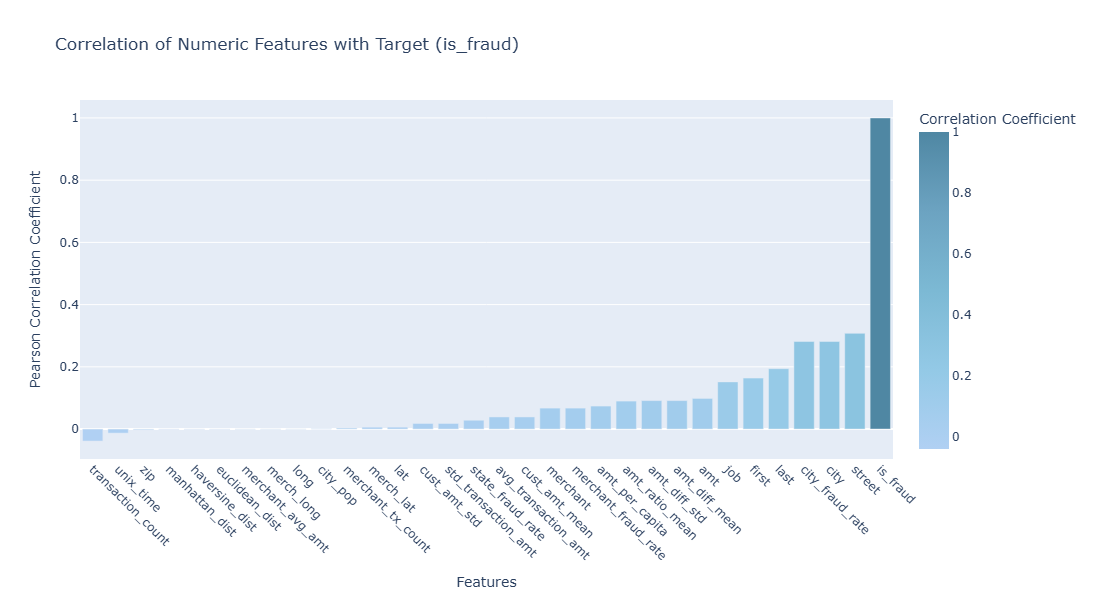

In [31]:
numeric_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features = [col for col in numeric_features if col != 'cc_num']

# Compute correlation with target
target_col = 'is_fraud'
features_for_corr = numeric_features.copy()
if target_col not in features_for_corr:
    features_for_corr.append(target_col)

correlation_with_target = train_df[features_for_corr].corr()[target_col].sort_values()

# Interactive bar chart
pastel_blue_colors = ['#b0d0f3', '#93c9e6', '#7cb9d4', '#6ca3c1', '#4f87a3']

fig = px.bar(
    x=correlation_with_target.index,
    y=correlation_with_target.values,
    labels={"x": "Features", "y": "Pearson Correlation Coefficient"},
    title=f"Correlation of Numeric Features with Target ({target_col})",
    color=correlation_with_target.values,
    color_continuous_scale=pastel_blue_colors
)

fig.update_layout(
    xaxis=dict(title="Features", tickangle=45),
    yaxis=dict(title="Pearson Correlation Coefficient"),
    coloraxis_colorbar=dict(title="Correlation Coefficient"),
    height=600,
    width=1000
)

fig.show()

## Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

numerical_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

scaler = MinMaxScaler()

train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])
test_df[numerical_features] = scaler.transform(test_df[numerical_features])
